In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data as td
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
froot = './data/k562_small'

df = pd.read_csv(froot + ".csv")

In [3]:
print(df.head())

   seqnames     start       end strand  ensembl_gene_id  score      ctcf  \
0         6  41077441  41077441      +  ENSG00000001167    0.0 -0.074159   
1         6  41077442  41077442      +  ENSG00000001167    0.0 -0.074217   
2         6  41077443  41077443      +  ENSG00000001167    0.0 -0.074276   
3         6  41077444  41077444      +  ENSG00000001167    0.0 -0.074336   
4         6  41077445  41077445      +  ENSG00000001167    0.0 -0.074398   

   h3k36me3   h3k4me1  h3k79me2  ...       sj3       dms      rpts  wgbs  \
0 -0.347414 -0.231637  1.630302  ... -0.057178 -0.307549  0.249626   0.0   
1 -0.346807 -0.231970  1.628545  ... -0.057178 -0.307549  0.249626   0.0   
2 -0.346199 -0.232304  1.626748  ... -0.057178 -0.307549  0.249626   0.0   
3 -0.345591 -0.232638  1.624913  ... -0.057178 -0.307549  0.249626   0.0   
4 -0.344983 -0.232972  1.623041  ... -0.057178 -0.307549  0.249626   0.0   

       A         T         G         C  lambda_alphaj      zeta  
0 -0.625  1.473964 -

In [4]:
df['gene_length'] = df.groupby('ensembl_gene_id')['ensembl_gene_id'].transform('count')

In [5]:
column_names = df.columns.tolist()
feature_names = column_names[6:-7]
nucleotides = column_names[-7:-3]
print(feature_names)
print(nucleotides)

# process read counts
X_ji = df.groupby('ensembl_gene_id')['score'].apply(list).tolist() 

# process GLM simulated elongation rates
Z_ji = df.groupby('ensembl_gene_id')['zeta'].apply(list).tolist() 

num_samples = len(X_ji)

['ctcf', 'h3k36me3', 'h3k4me1', 'h3k79me2', 'h3k9me1', 'h3k9me3', 'h4k20me1', 'sj5', 'sj3', 'dms', 'rpts', 'wgbs']
['A', 'T', 'G', 'C']


In [6]:
print(num_samples)

1502


In [7]:
def sliding_window(data, window_size):
    data = np.array(data)  # Convert data to a NumPy array for efficient operations
    num_sites = len(data)
    
    sub_sequences = []
    
    for i in range(num_sites):
        start = i - window_size // 2
        end = i + window_size // 2 + 1  # +1 to include the right edge
        
        # Ensure that the window is within the bounds of the sequence
        if start < 0:
            padding_start = abs(start)
            start = 0
        else:
            padding_start = 0
        
        if end > num_sites:
            padding_end = end - num_sites
            end = num_sites
        else:
            padding_end = 0
        
        window = data[start:end]
        
        # Pad the window if necessary
        if padding_start > 0 or padding_end > 0:
            window = np.pad(window, (padding_start, padding_end), mode='constant')
        
        sub_sequences.append(window)
    
    return sub_sequences

window_size = 201  # 100 sites to the left, 100 sites to the right, and the target site

In [8]:
X_ji_windows = []
for seq in X_ji:
    x_windows = sliding_window(seq, window_size)
    X_ji_windows.extend(x_windows)

In [9]:
Z_ji_windows = []
for seq in Z_ji:
    z_windows = sliding_window(seq, window_size)
    Z_ji_windows.extend(z_windows)

In [10]:
C_j = df.groupby('ensembl_gene_id')['lambda_alphaj'].apply(list).tolist() 

In [11]:
C_j_windows = []
for seq in C_j:
    c_windows = sliding_window(seq, window_size)
    C_j_windows.extend(c_windows)

In [12]:
from sklearn.preprocessing import MinMaxScaler

#Y_ji is a list of samples containing lists of their feature values
    # [   
    #   [[sample_1_feature_1], [sample_1_feature_2], [sample_1_feature_3]],
    #   [[sample_2_feature_1], [sample_2_feature_2], [sample_2_feature_3]],  
    # ]

#Y_ji = []

#for sample_id in df['ensembl_gene_id'].unique():
#    sample_data = [df[feature_name][df['ensembl_gene_id'] == sample_id].tolist() for feature_name in feature_names]
#    Y_ji.append(sample_data)

grouped_data = df.groupby('ensembl_gene_id')

# Initialize Y_ji as a list
Y_ji = []

# Iterate over groups in the grouped data
for _, group in grouped_data:
    # Extract features for each group
    sample_data = [group[feature_name].tolist() for feature_name in feature_names]
    Y_ji.append(sample_data)

In [ ]:
# normalize features
scaler = MinMaxScaler()
Y_ji = np.array(Y_ji)
# reshape dataset to [num_samples, num_features * feature_length]
Y_ji_reshaped = Y_ji.reshape(Y_ji.shape[0], -1)
normalized_Y_ji_reshaped = scaler.fit_transform(Y_ji_reshaped)
Y_ji = normalized_Y_ji_reshaped.reshape(Y_ji.shape)

In [13]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def process_sample(sample, window_size):
    sample_sub_sequences = []
    num_features = len(sample)
    max_entries = max(len(sample[j]) for j in range(num_features))
    
    for k in range(max_entries):
        current_window_group = []
        for j in range(num_features):
            sample_feature = np.array(sample[j])
            num_entries = len(sample_feature)

            start = k - window_size // 2
            end = k + window_size // 2 + 1  # +1 to include the right edge

            # Ensure that the window is within the bounds of the sequence
            if start < 0:
                padding_start = abs(start)
                start = 0
            else:
                padding_start = 0

            if end > num_entries:
                padding_end = end - num_entries
                end = num_entries
            else:
                padding_end = 0

            window = sample_feature[start:end]

            # Pad the window if necessary
            if padding_start > 0 or padding_end > 0:
                window = np.pad(window, (padding_start, padding_end), mode='constant')

            current_window_group.append(window)
        sample_sub_sequences.append(current_window_group)
    
    return sample_sub_sequences

def sliding_window_multi_feature(data, window_size):
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_sample, data, [window_size]*len(data)))
    
    sub_sequences = [item for sublist in results for item in sublist]
    return sub_sequences

In [14]:
Y_ji_windows = sliding_window_multi_feature(Y_ji, window_size)

In [15]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, Y_ji, X_ji, C_j, Z_ji):
        self.Y_ji = Y_ji
        self.X_ji = X_ji
        self.C_j = C_j
        self.Z_ji = Z_ji

    def __len__(self):
        return len(self.Y_ji)#X_ji)

    def __getitem__(self, idx):
        return {
            'Y_ji':  torch.tensor(np.array(self.Y_ji[idx]), dtype=torch.float32),
            'X_ji': torch.tensor(np.array(self.X_ji[idx]), dtype=torch.float32),
            'C_j': torch.tensor(np.array(self.C_j[idx]), dtype=torch.float32),
            'Z_ji': torch.tensor(np.array(self.Z_ji[idx]), dtype=torch.float32)
        }

In [16]:
print(len(X_ji_windows))

300400


In [17]:
dataset = CustomDataset(Y_ji_windows, X_ji_windows, C_j_windows, Z_ji_windows)

trnset, valset, tstset = td.random_split(dataset, [0.1,0.01,0.89])

trndl = DataLoader(trnset, batch_size=128, shuffle=True)
tstdl = DataLoader(tstset, batch_size=128, shuffle=False)
valdl = DataLoader(valset, batch_size=128, shuffle=False)

In [18]:
# trnset * batch_size
print(len(trndl))

235


Model(
  (fc1): Linear(in_features=2412, out_features=1500, bias=True)
  (fc2): Linear(in_features=1500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=250, bias=True)
  (fc4): Linear(in_features=250, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)
torch.Size([128, 1])
Number of parameters: 4495501


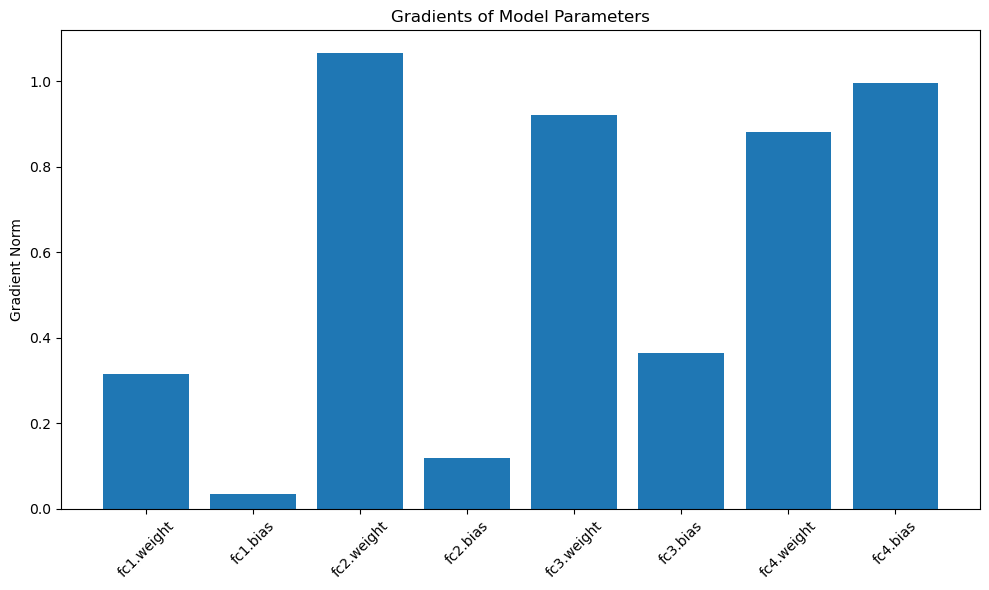

In [19]:
import torch.nn as nn
import torch.nn.init as init

class Model(nn.Module):
    def __init__(self):
       super(Model, self).__init__()
       self.fc1 = nn.Linear(2412, 1500)
       self.fc2 = nn.Linear(1500, 500)
       self.fc3 = nn.Linear(500, 250)
       self.fc4 = nn.Linear(250, 1)
       self.relu = nn.LeakyReLU()
       
       # Initialize weights using He initialization for each linear layer
       #init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
       #init.kaiming_normal_(self.fc4.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = torch.exp(self.fc4(x))#torch.exp(self.fc4(x)) # ensures all values are positive
        return x

# input size: [128, 12, 200]
model = Model()
print(model)

arr = torch.randn((128, 12, 201))#12,200))
print(model(arr).shape)
nparm = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: " + str(nparm))

output = model(arr)

# Compute gradients
output.mean().backward()

# Plot gradients
gradient_list = []
parameter_names = []

for name, param in model.named_parameters():
    if param.grad is not None:
        gradient_list.append(param.grad.norm().item())
        parameter_names.append(name)

plt.figure(figsize=(10, 6))
plt.bar(parameter_names, gradient_list)
plt.ylabel('Gradient Norm')
plt.title('Gradients of Model Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [20]:
import torch.nn.functional as F

class CustomLoss_1(nn.Module):
    def __init__(self):
        super(CustomLoss_1, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        print(Z_ji)
        epsilon = 1e-8
        clipped_Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(clipped_Z_ji) + C_j * torch.exp(-clipped_Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (loss).mean()

In [21]:
from sklearn.neighbors import KernelDensity
import torch.nn.functional as F

class CustomLoss_2(nn.Module):
    def __init__(self):
        super(CustomLoss_2, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        #print(Z_ji)
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        flat_Z_ji = Z_ji.view(-1)
        min_value = torch.min(flat_Z_ji)
        max_value = torch.max(flat_Z_ji)
        uniform_distribution = torch.ones_like(Z_ji) / (max_value - min_value)
        kde_Z_ji = torch.zeros_like(Z_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth="silverman")#0.5)
        for i in range(Z_ji.shape[0]):
            sample = Z_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_Z_ji[i] = kde_estimates.squeeze()
            
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        weights = uniform_distribution / kde_Z_ji.unsqueeze(1)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        # compute mean over batch to normalize due to varying batch sizes
        return (weights*loss).mean()

In [22]:
from sklearn.neighbors import KernelDensity

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, X_ji, C_j, Z_ji):
        epsilon = 1e-8
        #print("Z_ji")
        #print(Z_ji)
        #kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#bandwidth="silverman")
        #kde.fit((Z_ji).detach().numpy())
        #kde_Z_ji = torch.exp(torch.tensor(kde.score_samples(Z_ji.detach().numpy()), dtype=torch.float32))
        kde_X_ji = torch.zeros_like(X_ji, dtype=torch.float32)
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5)#"silverman")
        for i in range(X_ji.shape[0]):
            sample = X_ji[i].detach().numpy().reshape(-1, 1)  # Reshape to (200, 1)
            kde.fit(sample)
            kde_estimates = torch.exp(torch.tensor(kde.score_samples(sample), dtype=torch.float32))
            kde_X_ji[i] = kde_estimates.squeeze()
        min_value = torch.min(kde_X_ji)
        max_value = torch.max(kde_X_ji)

        # Normalize the KDE values to the range [0, 1]
        normalized_kde_values = (kde_X_ji - min_value) / (max_value - min_value)
        weights = 1 - (0.9 * normalized_kde_values)
        weights = torch.clamp(weights, epsilon)
        weights_sum = torch.sum(weights)
        normalized_weights = weights / weights_sum
        epsilon = 1e-8
        Z_ji = torch.clamp(Z_ji, epsilon)
        loss = X_ji * torch.log(Z_ji) + C_j * torch.exp(-Z_ji)
        #print("loss")
        #print(loss)
        #print("weights")
        #print(normalized_weights)
        # compute mean over batch to normalize due to varying batch sizes
        return (normalized_weights*loss).mean()


In [23]:
def plot_data(targets, outputs):
    indices = range(len(targets))#[0]))

    fig, axs = plt.subplots(3, 3, figsize=(15,15))
    for i in range(3):
        for j in range(3):
            axs[i, j].scatter(indices, targets[i+j*3], s=5)
            axs[i, j].scatter(indices, outputs.detach().numpy()[i+j*3], s=5)
            axs[i, j].set_ylim(-0.25, 1.3)

    plt.xlabel('Index')
    plt.ylabel('Elongation Rates')
    plt.legend(['GLM Elongation Rate', 'NN Elongation Rate'], loc='upper center', bbox_to_anchor=(0.5, -0.6))


In [30]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

model = Model()

num_epochs = 10#50

loss_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs

loss_fn = CustomLoss()#nn.L1Loss()#nn.MSELoss()

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}')
    model.train()
    for batch in trndl:
        optimizer.zero_grad()
        Y_ji_batch = batch['Y_ji']
        X_ji_batch = batch['X_ji']
        C_j_batch = batch['C_j']
        outputs = model(Y_ji_batch)
        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
        #loss = loss_fn(batch['Z_ji'], outputs)
        loss.backward()
        optimizer.step()
        loss_hist_train[epoch] += loss.item()
        #if epoch == 49:
         #   plot_data(batch['Z_ji'], outputs)
    loss_hist_train[epoch] /= len(trndl.dataset)
    scheduler.step()
    
    #model.eval()
    #with torch.no_grad():
    #    for batch in valdl:
    #        Y_ji_batch = batch['Y_ji']
    #        X_ji_batch = batch['X_ji']
    #        C_j_batch = batch['C_j']
    #        outputs = model(Y_ji_batch)
    #        loss = loss_fn(X_ji_batch, C_j_batch, outputs)
            #loss = loss_fn(batch['Z_ji'], outputs)
    #        loss_hist_valid[epoch] += loss.item()
    #    loss_hist_valid[epoch] /= len(valdl.dataset)
    
    print(f'Epoch {epoch+1} trn_loss: '
          f'{loss_hist_train[epoch]:.20f}')# val_loss: '
          #f'{loss_hist_valid[epoch]:.4f}')

Epoch 1
Epoch 1 trn_loss: 0.00000000487082652785
Epoch 2
Epoch 2 trn_loss: 0.00000000487191737936
Epoch 3
Epoch 3 trn_loss: 0.00000000486610959510
Epoch 4
Epoch 4 trn_loss: 0.00000000486394226283
Epoch 5
Epoch 5 trn_loss: 0.00000000486378855475
Epoch 6
Epoch 6 trn_loss: 0.00000000486715142484
Epoch 7
Epoch 7 trn_loss: 0.00000000487123898041
Epoch 8
Epoch 8 trn_loss: 0.00000000486898559110
Epoch 9
Epoch 9 trn_loss: 0.00000000486827861432
Epoch 10
Epoch 10 trn_loss: 0.00000000486473480561


In [24]:
torch.save(model.state_dict(), "mlp_sliding_window_model.pth")

In [25]:
model.load_state_dict(torch.load("mlp_sliding_window_model.pth"))

<All keys matched successfully>

In [26]:
from matplotlib import pyplot as plt
epochs = range(1, len(loss_hist_train) + 1)
plt.plot(epochs, loss_hist_train, label='train_loss')
plt.plot(epochs, loss_hist_valid, label='valid_loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show 

NameError: name 'loss_hist_train' is not defined

[0.925634509937596, 0.926355765607882, 0.927077435774806, 0.927799447423676, 0.928521619338566, 0.929243909074127, 0.929966206372222, 0.930688313277454, 0.931410210185511, 0.932131783780025, 0.932852925950873, 0.933573555910864, 0.934293541340124, 0.935012790994746, 0.772677364958486, 0.936448602136156, 0.937164954043454, 0.937880131662011, 0.938594032063029, 0.939306556524647, 0.940017600660797, 0.940727063907469, 0.941434846755665, 0.942140900878425, 0.942845080543211, 0.943547289629761, 0.944247458535066, 0.944945464975962, 0.945641215577509, 0.946334636669673, 0.947025615080406, 0.947714063977334, 0.94839982958302, 0.949082892959954, 0.94976316190685, 0.950440554644898, 0.951114984088754, 0.951786406814957, 0.952454706039358, 0.78703596686167, 0.953781644759594, 0.954440134400499, 0.95509519169426, 0.955746746154993, 0.956394722185857, 0.957039049174317, 0.957679620251572, 0.958316404132692, 0.958949333422898, 0.959578405049989, 0.960203494053218, 0.960824539406058, 0.9614414817348

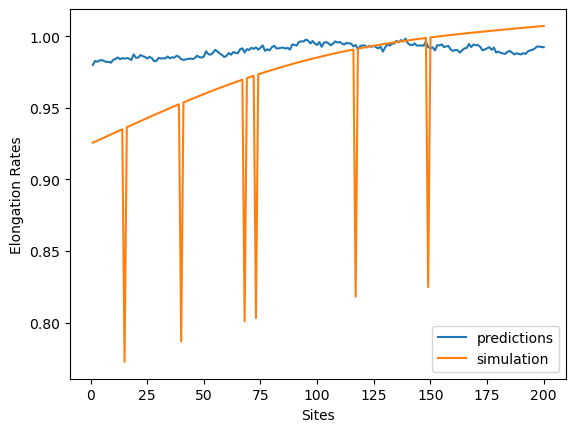

In [31]:
model.eval()

y_test = [Y_ji[2]]

Y_ji_test_windows = sliding_window_multi_feature(y_test, 201)

with torch.no_grad():
    outputs = model(torch.Tensor(Y_ji_test_windows))
    
outputs = outputs.view(-1).tolist()
print(Z_ji[2])
print(outputs)
z_values = np.array(range(1, len(outputs) + 1))

plt.plot(z_values, outputs, label="predictions")
plt.plot(z_values, Z_ji[2], label="simulation")

plt.xlabel('Sites')
plt.ylabel('Elongation Rates')
plt.legend()
plt.show()

In [39]:

inputs = next(iter(tstdl))#tstdl)) 
print("number of samples: " + str(len(inputs)))

with torch.no_grad():
    outputs = model(inputs['Y_ji'])#'Y_ji'])
    
#outputs = torch.exp(outputs)
print(outputs)

targets = inputs['Z_ji']
print(targets)

print(targets.shape)
print(outputs.shape)

#plot_data(targets, outputs)

#for batch in trndl:
#    targets = inputs['Z_ji']
#    outputs = model(inputs['X_ji'])#'Y_ji'])
#    outputs = torch.exp(outputs)
    
#    plot_data(targets, outputs)

number of samples: 4
tensor([[1.0667],
        [1.0228],
        [1.0309],
        [1.1340],
        [1.0519],
        [1.0712],
        [1.0325],
        [1.0405],
        [1.0488],
        [1.0939],
        [1.0306],
        [1.1207],
        [1.1336],
        [1.0446],
        [1.0324],
        [1.0611],
        [1.0536],
        [1.0426],
        [1.0444],
        [1.0424],
        [1.0403],
        [1.0559],
        [1.0378],
        [1.0458],
        [1.1620],
        [1.0955],
        [1.0465],
        [1.0624],
        [1.0324],
        [1.0270],
        [1.0742],
        [1.0391],
        [1.0498],
        [1.0780],
        [1.0222],
        [1.0463],
        [1.0566],
        [1.0590],
        [1.0351],
        [1.0622],
        [1.0404],
        [1.0331],
        [1.0675],
        [1.0653],
        [1.0675],
        [1.0461],
        [1.0383],
        [1.0186],
        [1.0468],
        [1.0283],
        [1.0663],
        [1.0505],
        [1.0359],
        [1.0587],
       